# Projeto 20: Previsão do preço de ações com Redes Neurais Recorrentes

In [1]:
!pip install torch==1.4.0

## Etapa 1: Importação das bibliotecas

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch import nn, optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

In [3]:
torch.manual_seed(123)

## Base de dados

In [4]:
df_train = pd.read_csv('/content/petr4_treinamento.csv')
df_test = pd.read_csv('/content/petr4_teste.csv')

In [5]:
df_train.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,19.990000,20.209999,19.690001,19.690001,18.086271,30182600.0
1,2013-01-03,19.809999,20.400000,19.700001,20.400000,18.738441,30552600.0
2,2013-01-04,20.330000,20.620001,20.170000,20.430000,18.766001,36141000.0
3,2013-01-07,20.480000,20.670000,19.950001,20.080000,18.444506,28069600.0
4,2013-01-08,20.110001,20.230000,19.459999,19.500000,17.911745,29091300.0


In [6]:
df_train.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1240,2017-12-25,15.75,15.750000,15.75,15.750000,15.718563,0.0
1241,2017-12-26,15.75,15.990000,15.69,15.970000,15.938125,22173100.0
1242,2017-12-27,15.99,16.139999,15.98,16.049999,16.017963,23552200.0
1243,2017-12-28,16.10,16.129999,16.00,16.100000,16.067865,19011500.0
1244,2017-12-29,16.10,16.100000,16.10,16.100000,16.067865,0.0


In [7]:
df_train.shape

(1245, 7)

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1245 entries, 0 to 1244
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1245 non-null   object 
 1   Open       1242 non-null   float64
 2   High       1242 non-null   float64
 3   Low        1242 non-null   float64
 4   Close      1242 non-null   float64
 5   Adj Close  1242 non-null   float64
 6   Volume     1242 non-null   float64
dtypes: float64(6), object(1)
memory usage: 68.2+ KB


In [9]:
df_train.isnull().sum()

Date         0
Open         3
High         3
Low          3
Close        3
Adj Close    3
Volume       3
dtype: int64

In [10]:
df_train.dropna(inplace=True)
df_train.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [11]:
df_train.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1242.000000,1242.000000,1242.000000,1242.000000,1242.000000,1.242000e+03
mean,14.041473,14.279831,13.785217,14.017415,13.699826,4.595294e+07
std,4.148311,4.186652,4.108178,4.146244,3.899735,3.235631e+07
min,4.200000,4.270000,4.120000,4.200000,4.191617,0.000000e+00
25%,10.510000,10.772500,10.210000,10.510000,10.489022,2.909925e+07
50%,14.545000,14.690000,14.220000,14.440000,14.209791,4.097120e+07
75%,17.187501,17.435001,16.870001,17.112501,16.383754,5.593528e+07
max,24.840000,24.900000,23.660000,24.559999,24.510979,6.989506e+08


In [12]:
df_grp = df_train.copy()
df_grp['Date'] = df_grp['Date'].apply(lambda x: x[:-3])
df_grp = df_grp.groupby('Date').mean().reset_index()
df_grp.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01,19.698095,19.874762,19.384286,19.573810,17.979544,2.635205e+07
1,2013-02,17.565000,17.768889,17.337778,17.537778,16.109345,3.152355e+07
2,2013-03,18.376842,18.738421,18.130526,18.423158,16.922611,3.226189e+07
3,2013-04,18.240476,18.583810,17.998572,18.308095,16.833584,3.010713e+07
4,2013-05,19.997619,20.257143,19.766190,20.008095,18.726952,2.737860e+07


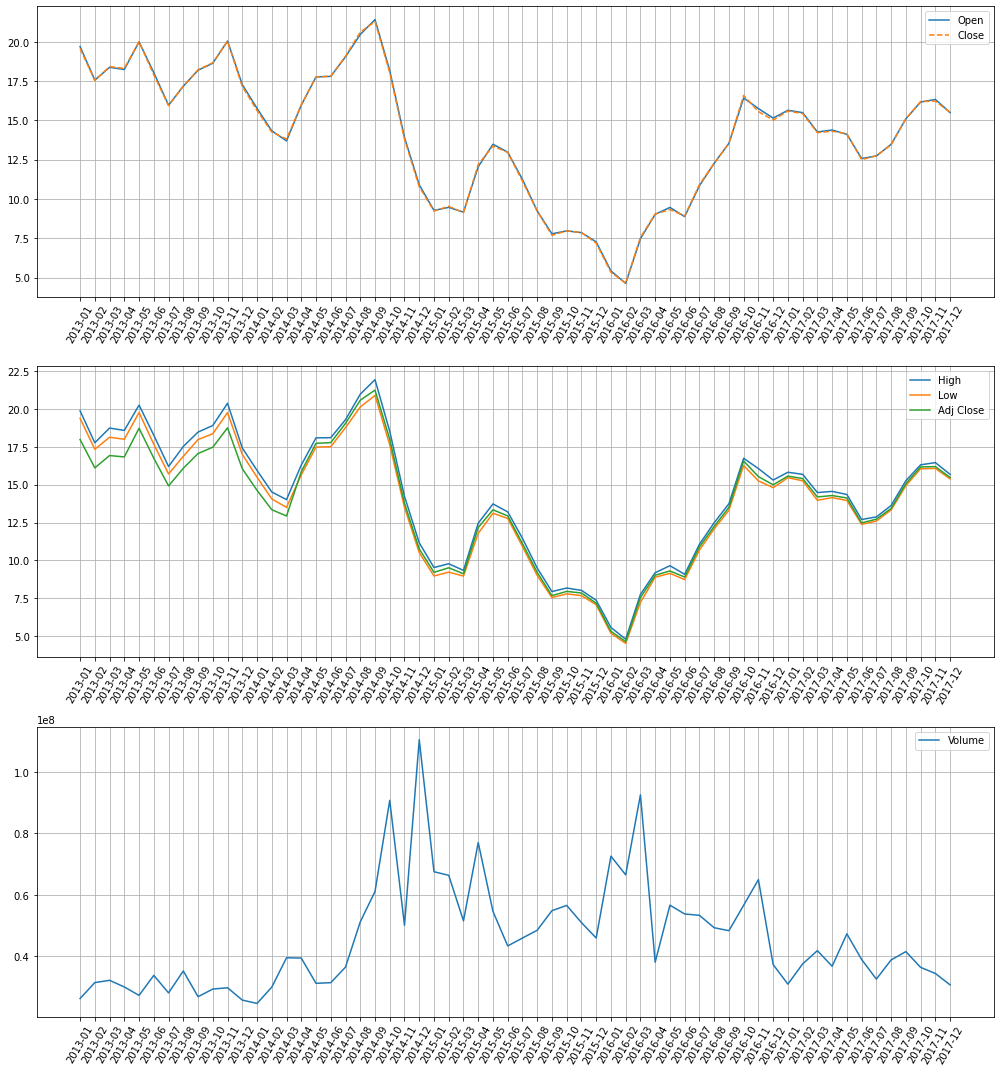

In [13]:
fig, ax = plt.subplots(3,1, figsize=(14,15))
ax[0].plot(df_grp['Date'], df_grp['Open'], label='Open')
ax[0].plot(df_grp['Date'], df_grp['Close'], label='Close', linestyle='--')
ax[0].xaxis.set_tick_params(rotation=60)
ax[0].grid()
ax[0].legend()

ax[1].plot(df_grp['Date'], df_grp['High'], label='High')
ax[1].plot(df_grp['Date'], df_grp['Low'], label='Low')
ax[1].plot(df_grp['Date'], df_grp['Adj Close'], label='Adj Close')
ax[1].xaxis.set_tick_params(rotation=60)
ax[1].grid()
ax[1].legend()

ax[2].plot(df_grp['Date'], df_grp['Volume'], label='Volume')
ax[2].xaxis.set_tick_params(rotation=60)
ax[2].grid()
ax[2].legend()

plt.tight_layout();

In [14]:
X_train = df_train.iloc[:,1:2].values
X_train

array([[19.99    ],
       [19.809999],
       [20.33    ],
       ...,
       [15.99    ],
       [16.1     ],
       [16.1     ]])

In [15]:
norm_scaler = MinMaxScaler(feature_range=(0,1))
X_scaled = norm_scaler.fit_transform(X_train)
X_scaled

array([[0.76501938],
       [0.7562984 ],
       [0.78149225],
       ...,
       [0.57122093],
       [0.57655039],
       [0.57655039]])

In [16]:
X_scaled.shape

(1242, 1)

In [17]:
X, y = [], []
for i in range(90, X_scaled.shape[0]):
  X.append(X_scaled[i-90:i, 0])
  y.append(X_scaled[i, 0])
X, y = np.array(X), np.array(y)

In [18]:
X[0]

array([0.76501938, 0.7562984 , 0.78149225, 0.78875969, 0.77083338,
       0.74806197, 0.75436047, 0.75823643, 0.76598837, 0.76598837,
       0.76017437, 0.75872098, 0.75581391, 0.74467054, 0.7374031 ,
       0.7374031 , 0.73498067, 0.75242248, 0.73401163, 0.71656977,
       0.68120155, 0.67538755, 0.67635659, 0.63372098, 0.66521318,
       0.65649225, 0.64680228, 0.66618222, 0.65843028, 0.64970935,
       0.65116274, 0.66424419, 0.67344961, 0.64292631, 0.64486434,
       0.62257747, 0.60949617, 0.60998067, 0.60852713, 0.59593023,
       0.61143411, 0.60222863, 0.64922481, 0.68362398, 0.70687989,
       0.68265509, 0.70978682, 0.70784879, 0.71608527, 0.73643411,
       0.7122093 , 0.7122093 , 0.7194767 , 0.70348832, 0.69525189,
       0.70397287, 0.70397287, 0.69767442, 0.68168605, 0.68168605,
       0.65310078, 0.66618222, 0.64825581, 0.66182175, 0.64341085,
       0.67877902, 0.69137592, 0.66569772, 0.65406982, 0.64292631,
       0.64147292, 0.63565891, 0.67587209, 0.68653106, 0.70300

In [19]:
y[0]

0.7611434108527131

In [20]:
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

In [21]:
dataset = torch.utils.data.TensorDataset(X, y)
loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

## Etapa 3: Construção da rede neural recorrente

In [22]:
class Reg_LSTM(nn.Module):
  def __init__(self):
    super(Reg_LSTM, self).__init__()

    self.lstm1 = nn.LSTM(input_size=1, hidden_size=100)
    self.lstm2 = nn.LSTM(100, 50)
    self.lstm3 = nn.LSTM(50,50, dropout=0.3, num_layers=2)
    self.dropout = nn.Dropout(p=0.3)
    self.linear = nn.Linear(in_features=50, out_features=1)

  def forward(self, X):
    # X = (batch_size, timesteps) => (timesteps, batch_size, dimensions)
    X = X.permute(1,0).unsqueeze(2)
    X, _ = self.lstm1(X)
    X = self.dropout(X)
    X, _ = self.lstm2(X)
    X = self.dropout(X)
    X, _ = self.lstm3(X)

    X = X[-1]
    X = self.dropout(X)
    X = self.linear(X)

    return X

In [23]:
device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
device

device(type='cuda')

In [24]:
reg = Reg_LSTM()
criterion = nn.MSELoss()
optimizer = optim.RMSprop(reg.parameters(), lr = 1e-3, alpha = 0.9)

In [25]:
reg.to(device)

Reg_LSTM(
  (lstm1): LSTM(1, 100)
  (lstm2): LSTM(100, 50)
  (lstm3): LSTM(50, 50, num_layers=2, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

## Etapa 4: Treinamento do modelo

In [26]:
arr_loss, arr_mae = [], []
reg.train()
for epoch in range(100):

  run_loss = 0.
  run_mae = 0.

  for i, data in enumerate(loader):
    
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()

    outputs = reg(inputs)
    outputs = outputs.flatten()

    loss = criterion(outputs, labels)
    loss.backward()

    optimizer.step()

    run_loss += loss.item()
    mae = mean_absolute_error(labels.detach().cpu().numpy().flatten(),
                              outputs.detach().cpu().numpy().flatten())
    
    run_mae += mae

    print('\rÉpoca {:3d} - Loop {:3d} de {:3d}: custo {:03.5f} | MAE {:03.5f}' \
          .format(epoch+1, i+1, len(loader), loss, mae), end='\r')
    
  run_loss /= len(loader)
  run_mae /= len(loader)
  arr_loss.append(run_loss)
  arr_mae.append(run_mae)
  print('ÉPOCA {:3d} FINALIZADA: custo {:03.6f} | MAE {:03.6f}      ' \
        .format(epoch+1, run_loss, run_mae))


ÉPOCA   1 FINALIZADA: custo 0.046852 | MAE 0.173007      
ÉPOCA   2 FINALIZADA: custo 0.027306 | MAE 0.133812      
ÉPOCA   3 FINALIZADA: custo 0.015588 | MAE 0.100124      
ÉPOCA   4 FINALIZADA: custo 0.013585 | MAE 0.091310      
ÉPOCA   5 FINALIZADA: custo 0.010561 | MAE 0.079635      
ÉPOCA   6 FINALIZADA: custo 0.009625 | MAE 0.074324      
ÉPOCA   7 FINALIZADA: custo 0.009418 | MAE 0.076973      
ÉPOCA   8 FINALIZADA: custo 0.007104 | MAE 0.065098      
ÉPOCA   9 FINALIZADA: custo 0.007482 | MAE 0.067496      
ÉPOCA  10 FINALIZADA: custo 0.007035 | MAE 0.065768      
ÉPOCA  11 FINALIZADA: custo 0.006531 | MAE 0.061649      
ÉPOCA  12 FINALIZADA: custo 0.005745 | MAE 0.060106      
ÉPOCA  13 FINALIZADA: custo 0.005448 | MAE 0.057018      
ÉPOCA  14 FINALIZADA: custo 0.005431 | MAE 0.056897      
ÉPOCA  15 FINALIZADA: custo 0.004875 | MAE 0.055244      
ÉPOCA  16 FINALIZADA: custo 0.005025 | MAE 0.055329      
ÉPOCA  17 FINALIZADA: custo 0.004883 | MAE 0.054139      
ÉPOCA  18 FINA

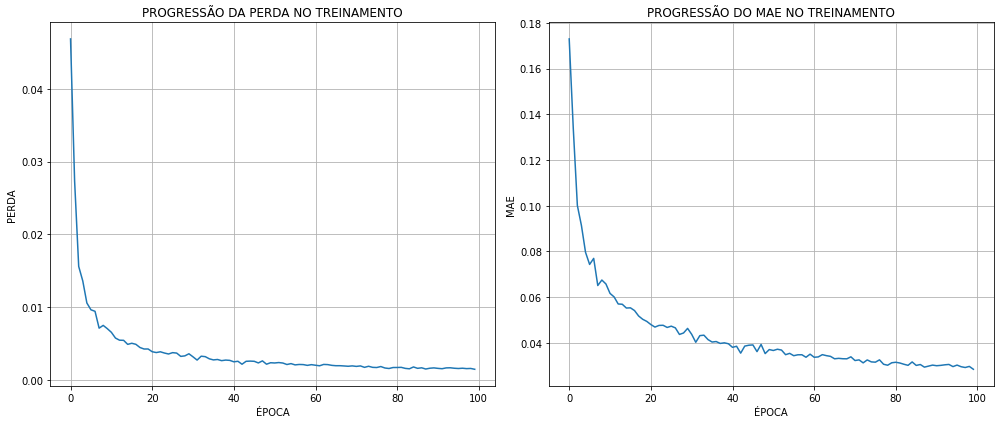

In [27]:
fig, ax = plt.subplots(1,2, figsize=(14,6))

ax[0].plot(arr_loss, label='Perda')
ax[0].set(xlabel='ÉPOCA', ylabel='PERDA', title='PROGRESSÃO DA PERDA NO TREINAMENTO')
ax[0].grid()

ax[1].plot(arr_mae, label='MAE')
ax[1].set(xlabel='ÉPOCA', ylabel='MAE', title='PROGRESSÃO DO MAE NO TREINAMENTO')
ax[1].grid()

plt.tight_layout();

## Etapa 5: Processamento da base de teste

In [28]:
df_test.shape

(22, 7)

In [29]:
df_train.head(22)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,19.990000,20.209999,19.690001,19.690001,18.086271,30182600.0
1,2013-01-03,19.809999,20.400000,19.700001,20.400000,18.738441,30552600.0
2,2013-01-04,20.330000,20.620001,20.170000,20.430000,18.766001,36141000.0
3,2013-01-07,20.480000,20.670000,19.950001,20.080000,18.444506,28069600.0
4,2013-01-08,20.110001,20.230000,19.459999,19.500000,17.911745,29091300.0
5,2013-01-09,19.639999,19.870001,19.459999,19.680000,18.077084,24361100.0
6,2013-01-10,19.770000,20.049999,19.540001,19.830000,18.214869,17526200.0
7,2013-01-11,19.850000,20.040001,19.700001,19.879999,18.260794,18223600.0
8,2013-01-14,20.010000,20.240000,19.690001,19.719999,18.113827,28302400.0
9,2013-01-15,20.010000,20.240000,19.690001,19.820000,18.205681,29633900.0


In [30]:
X_raw = df_test.iloc[:, 1:2].values
X_raw

array([[16.190001],
       [16.49    ],
       [16.780001],
       [16.700001],
       [16.74    ],
       [17.030001],
       [16.92    ],
       [16.879999],
       [17.040001],
       [17.32    ],
       [17.35    ],
       [17.92    ],
       [18.35    ],
       [18.309999],
       [18.26    ],
       [18.4     ],
       [18.42    ],
       [19.34    ],
       [19.620001],
       [19.67    ],
       [19.77    ],
       [19.74    ]])

In [31]:
df_completa = pd.concat((df_train['Open'], df_test['Open']), axis=0)
df_completa.shape

(1264,)

In [32]:
entradas = df_completa[len(df_completa) - len(df_test) - 90:].values
entradas

array([13.93    , 13.76    , 13.79    , 13.53    , 13.85    , 13.96    ,
       14.57    , 14.65    , 15.02    , 15.1     , 14.88    , 14.98    ,
       14.94    , 15.03    , 15.07    , 15.02    , 15.1     , 15.25    ,
       15.85    , 15.6     , 15.79    , 15.86    , 15.7     , 15.37    ,
       15.5     , 15.19    , 15.6     , 15.9     , 15.88    , 15.66    ,
       15.61    , 16.129999, 16.17    , 16.08    , 16.23    , 16.16    ,
       16.139999, 16.219999, 16.      , 16.190001, 16.290001, 16.290001,
       16.530001, 16.780001, 16.77    , 16.969999, 16.9     , 16.99    ,
       16.9     , 16.959999, 17.049999, 17.309999, 16.690001, 16.889999,
       16.709999, 16.690001, 16.639999, 15.35    , 15.62    , 15.92    ,
       16.02    , 16.15    , 16.09    , 15.98    , 16.25    , 16.01    ,
       15.93    , 15.87    , 15.3     , 15.34    , 15.65    , 15.5     ,
       15.22    , 15.3     , 15.51    , 15.48    , 15.36    , 15.65    ,
       15.1     , 15.05    , 15.16    , 15.18    , 

In [33]:
entradas.shape

(112,)

In [34]:
entradas = entradas.reshape(-1,1)
entradas.shape

(112, 1)

In [35]:
entradas = norm_scaler.transform(entradas)
entradas

array([[0.47141473],
       [0.46317829],
       [0.46463178],
       [0.45203488],
       [0.46753876],
       [0.47286822],
       [0.50242248],
       [0.50629845],
       [0.52422481],
       [0.52810078],
       [0.51744186],
       [0.52228682],
       [0.52034884],
       [0.5247093 ],
       [0.52664729],
       [0.52422481],
       [0.52810078],
       [0.53536822],
       [0.56443798],
       [0.55232558],
       [0.56153101],
       [0.56492248],
       [0.55717054],
       [0.54118217],
       [0.54748062],
       [0.53246124],
       [0.55232558],
       [0.56686047],
       [0.56589147],
       [0.55523256],
       [0.55281008],
       [0.57800383],
       [0.57994186],
       [0.5755814 ],
       [0.58284884],
       [0.57945736],
       [0.57848832],
       [0.58236429],
       [0.57170543],
       [0.5809109 ],
       [0.58575586],
       [0.58575586],
       [0.59738377],
       [0.60949617],
       [0.60901163],
       [0.6187015 ],
       [0.61531008],
       [0.619

In [36]:
X_test = []
for i in range(90, 112):
  X_test.append(entradas[i-90:i, 0])
X_test = np.array(X_test)
X_test[21]

array([0.56492248, 0.55717054, 0.54118217, 0.54748062, 0.53246124,
       0.55232558, 0.56686047, 0.56589147, 0.55523256, 0.55281008,
       0.57800383, 0.57994186, 0.5755814 , 0.58284884, 0.57945736,
       0.57848832, 0.58236429, 0.57170543, 0.5809109 , 0.58575586,
       0.58575586, 0.59738377, 0.60949617, 0.60901163, 0.6187015 ,
       0.61531008, 0.61967054, 0.61531008, 0.61821701, 0.62257747,
       0.63517437, 0.60513571, 0.61482553, 0.6061046 , 0.60513571,
       0.60271313, 0.54021318, 0.55329457, 0.56782946, 0.57267442,
       0.57897287, 0.57606589, 0.57073643, 0.58381783, 0.57218992,
       0.56831395, 0.56540698, 0.5377907 , 0.53972868, 0.55474806,
       0.54748062, 0.53391473, 0.5377907 , 0.54796512, 0.54651163,
       0.54069767, 0.55474806, 0.52810078, 0.52567829, 0.53100775,
       0.53197674, 0.53343023, 0.53827519, 0.55959302, 0.55959302,
       0.55959302, 0.57122093, 0.57655039, 0.57655039, 0.5809109 ,
       0.59544574, 0.60949617, 0.6056202 , 0.60755814, 0.62160

In [37]:
X_test = torch.tensor(X_test, device = device, dtype=torch.float32)

## Etapa 6: Previsões

In [38]:
reg.eval()
previsoes = reg.forward(X_test)

In [39]:
previsoes

tensor([[0.5713],
        [0.5744],
        [0.5861],
        [0.6005],
        [0.6016],
        [0.6022],
        [0.6127],
        [0.6125],
        [0.6100],
        [0.6148],
        [0.6268],
        [0.6316],
        [0.6527],
        [0.6748],
        [0.6791],
        [0.6774],
        [0.6814],
        [0.6833],
        [0.7164],
        [0.7360],
        [0.7426],
        [0.7473]], device='cuda:0', grad_fn=<AddmmBackward>)

In [40]:
previsoes.shape

torch.Size([22, 1])

In [41]:
previsoes = previsoes.detach().cpu().numpy().reshape(-1,1)
previsoes.shape

(22, 1)

In [42]:
previsoes = norm_scaler.inverse_transform(previsoes)
previsoes.mean()

17.555431

In [43]:
X_raw.mean()

17.87454563636364

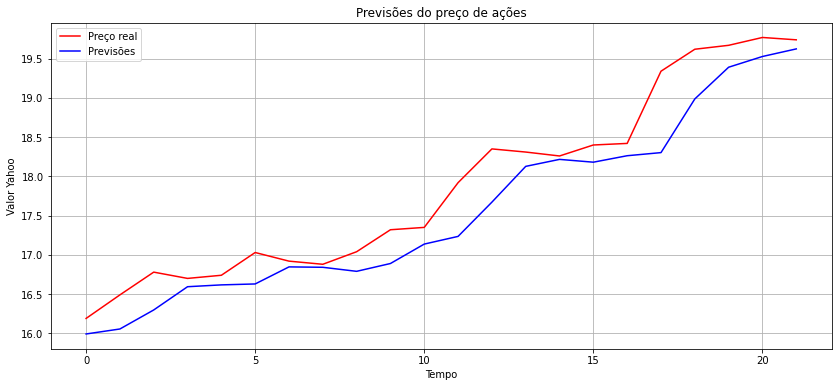

In [45]:
plt.figure(figsize=(14,6))
plt.plot(X_raw, color='red', label='Preço real')
plt.plot(previsoes, color = 'blue', label='Previsões')
plt.title('Previsões do preço de ações')
plt.xlabel('Tempo')
plt.ylabel('Valor Yahoo')
plt.legend()
plt.grid()
plt.show()